<a href="https://colab.research.google.com/github/aarunishsinha/SKFR-Python/blob/main/skfr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/BTP/SKFR_our

/content/drive/MyDrive/Colab Notebooks/BTP/SKFR_our


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as nmi, adjusted_rand_score as ari
from sklearn.cluster import KMeans
import random
import warnings
warnings.filterwarnings('ignore')

## Simple k-means (sklearn)

In [ ]:
def kmeans(X, k):
    km = KMeans(
        n_clusters=k, init='random',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )
    cluster = km.fit_predict(X)
    centroids = km.cluster_centers_
    return centroids, cluster

## Utility functions

In [ ]:
def zscore(vec):
    m = np.mean(vec)
    s = np.std(vec)
    if s!=0:
        zs = (vec-m)/s
    else:
        zs = vec-m
    return zs
    
def scale(y, scale=True, center=True):
    x = y.copy()
    if center:
        x -= np.mean(x)
    if scale and center:
        x /= np.std(x)
    elif scale:
        x /= np.sqrt(x.pow(2).sum().div(x.count()-1))
    return x

## SKFR-1

In [ ]:
 def skfr1(X,Class,classes,sparsity):
    features = X.shape[0]
    cases = X.shape[1]
    center = np.zeros((features,classes))
    members = np.zeros(classes)
    criteria = np.zeros(features)
    distance = np.zeros((classes,cases))
    wholevec = np.arange(0,features)

    for i in range(features):
        X[i,:] = zscore(X[i,:])

    switched = True
    iternum = 1
    importantvec = np.zeros(sparsity)
    loss_list = []
    while switched:
        center = np.zeros((features,classes))
        members = np.zeros(classes)
        for j in range(cases):
            i = Class[j]
            center[:,i] = center[:,i] + X[:,j]
            members[i] = members[i] + 1
        for j in range(classes):
            if members[j]>0:
                center[:,j] = center[:,j]/members[j]
        for i in range(features):
            criteria[i] = 0
            for j in range(classes):
                criteria[i] = criteria[i] + members[j]*((center[i][j])**2)
        sorted_criteria = sorted(criteria)
        hash_map = {}
        for i in range(len(criteria)):
            hash_map[criteria[i]] = i
        J = []
        for i in range(len(criteria)):
            J += [hash_map[sorted_criteria[i]]]
        J = np.array(J)
        J = J[:features-sparsity]
        importantvec = list(set(wholevec)-set(J))
        for i in range(len(J)):
            center[J[i]] = np.zeros(classes)
        for i in range(classes):
            for j in range(cases):
                distance[i][j] = np.sqrt(np.sum((center[:,i]-X[:,j])**2))
        switched = False
        for i in range(cases):
            j = np.argmin(distance[:,i])
            if j!=Class[i]:
                switched =True
                Class[i] = j
        WSStemp = np.zeros(classes)
        for k in range(classes):
            tempIndex = np.where(Class==k)[0]
            tempX = np.zeros((features,len(tempIndex)))
            for j in range(len(tempIndex)):
                tempX[:,j] = X[:,tempIndex[j]]
            WSStemp[k] = np.mean(((tempX.T-center[:,k]).T)**2)
        loss = np.sum(WSStemp)
        loss_list.append(loss)
        # print('Iteration : {}, Loss : {}'.format(iternum, loss))
        iternum += 1

    # WSSval = np.zeros(classes)
    # for k in range(classes):
    #     tempIndex = np.where(Class==k)[0]
    #     tempX = np.zeros((features,len(tempIndex)))
    #     for j in range(len(tempIndex)):
    #         tempX[:,j] = X[:,tempIndex[j]]
        # tempX_centered = (scale(tempX, scale=False, center=True))**2
        # WSSval[k] = np.sum(tempX)
    # X_centered = (scale(X, scale=False, center=True))**2
    # TSSval = np.sum(X_centered)
    # final_loss = np.sum(WSSval)
    # print('Final Loss : {}'.format(final_loss))
    # return(center, Class, WSSval, TSSval, X_centered)
    return center, Class, loss_list

## SKFR-2

In [ ]:
def skfr2(X,Class,classes,sparsity):
    features = X.shape[0]
    cases = X.shape[1]
    center = np.zeros((features,classes))
    members = np.zeros(classes)
    criteria = np.zeros(features)
    distance = np.zeros((classes,cases))
    importantvec = np.zeros((classes, sparsity))
    wholevec = np.arange(0,features)

    for i in range(features):
        X[i,:] = zscore(X[i,:])
    
    switched = True
    loss_list = []
    while switched:
        center = np.zeros((features,classes))
        members = np.zeros(classes)
        for j in range(cases):
            i = Class[j]
            center[:,i] = center[:,i] + X[:,j]
            members[i] = members[i] + 1
        for i in range(classes):
            if members[i]>0:
                center[:,i] = center[:,i]/members[i]
                sorted_center = sorted((center[:,i]**2)*members[i])
                hash_map = {}
                vec = (center[:,i]**2)*members[i]
                for j in range(len(vec)):
                    hash_map[vec[j]] = j
                J = []
                for j in range(len(vec)):
                    J += [hash_map[sorted_center[j]]]
                J = np.array(J)
                J = J[:features-sparsity]
                for j in J:
                    center[j,i] = 0
                importantvec = np.array(list(set(wholevec)-set(J)))
        switched = False
        for i in range(classes):
            for j in range(cases):
                distance[i][j] = np.sqrt(np.sum((center[:,i]-X[:,j])**2))
        for i in range(cases):
            j = np.argmin(distance[:,i])
            if j!=Class[i]:
                switched =True
                Class[i] = j
        WSStemp = np.zeros(classes)
        for k in range(classes):
            tempIndex = np.where(Class==k)[0]
            tempX = np.zeros((features,len(tempIndex)))
            for j in range(len(tempIndex)):
                tempX[:,j] = X[:,tempIndex[j]]
            WSStemp[k] = np.mean(((tempX.T-center[:,k]).T)**2)
        loss = np.sum(WSStemp)
        loss_list.append(loss)
        # print('Iteration : {}, Loss : {}'.format(iternum, loss))
        # iternum += 1

    # WSSval = np.zeros(classes)
    # for k in range(classes):
    #     tempIndex = np.where(Class==k)[0]
    #     tempX = np.zeros((features,len(tempIndex)))
    #     for j in range(len(tempIndex)):
    #         tempX[:,j] = X[:,tempIndex[j]]
        # tempX_centered = (scale(tempX, scale=False, center=True))**2
        # WSSval[k] = np.sum(tempX)
    # X_centered = (scale(X, scale=False, center=True))**2
    # TSSval = np.sum(X_centered)
    # final_loss = np.sum(WSSval)
    # print('Final Loss : {}'.format(final_loss))
    # return(center, Class, WSSval, TSSval, X_centered)
    return center, Class, loss_list

## Plotting Functions

In [ ]:
def plot_data(X):
    plt.scatter(
    X[:, 0], X[:, 1],
    c='white', marker='o',
    edgecolor='black', s=50
    )
    plt.show()

def plot_clusters(X,centroids,cluster):
    sns.scatterplot(X[:,0], X[:, 1], hue=cluster)
    sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
    plt.xlabel('feature1')
    plt.ylabel('feature2')
    plt.show()

def plot_loss(loss_list):
    epochs = [i for i in range(len(loss_list))]
    plt.plot(epochs,loss_list)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

## Process Data

In [ ]:
def processed_data(X):
    features = X.shape[0]
    cases = X.shape[1]
    m = features//3
    n = 2*m
    r = cases//3 + 1
    s = 2*(r - 1)
    for i in range(m):
        for j in range(r-1,s):
            X[i][j] += 1.0

    for i in range(m):
        for j in range(s,cases):
            X[i][j] += 2.0
    return X

##Comparision

In [ ]:
X = pd.read_csv("X.csv").values
Class = pd.read_csv("class.csv").values.reshape(-1,)
for i in range(len(Class)):
    Class[i]-=1
features = 100
cases = 300
classes = 3
sparsity = 33
X = processed_data(X)

(100, 300) (300,)
[[-7.72012101e-01 -8.10432793e-01 -7.76961259e-01 -7.88818696e-01
  -7.77434676e-01 -7.97767706e-01 -7.52164380e-01 -8.35476013e-01
  -7.00753989e-01 -7.95794430e-01 -6.55519060e-01 -7.68070397e-01
  -8.74716965e-01 -8.71049041e-01 -7.89885800e-01 -7.51399673e-01
  -7.55440034e-01 -8.08844324e-01 -8.07253681e-01 -7.85207737e-01
  -7.60192364e-01 -7.96466695e-01 -8.01467361e-01 -8.47307802e-01
  -7.99447573e-01 -7.88753817e-01 -7.97969858e-01 -7.76478373e-01
  -7.12926580e-01 -7.41499895e-01 -8.18689655e-01 -7.43690142e-01
  -8.99253813e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

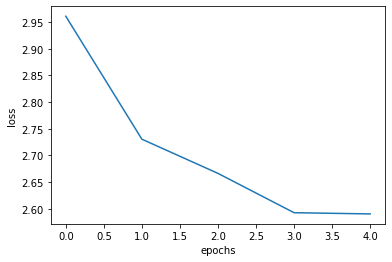

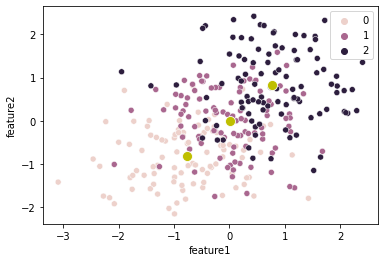

In [ ]:
print(X.shape, Class.shape)
centroids, cluster, loss_list = skfr1(X,Class,3,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)

(100, 300) (300,)
[[ 0.86915498  0.79231691  0.86031645  0.73693356  0.94824911  0.81810074
   0.90476898  0.78805831  0.76887071  0.78941813  0.72549827  0.78969282
   0.71901445  0.79135944  0.76123064  0.7354381   0.84245875  0.76046867
   0.81372807  0.77641417  0.76108524  0.78169136  0.83349948  0.82485984
   0.75179096  0.77014105  0.78704558  0.70492177  0.70356701  0.71832532
   0.7569728   0.79728976  0.80315141  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0. 

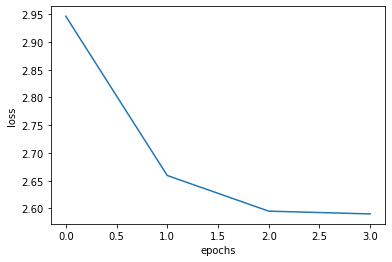

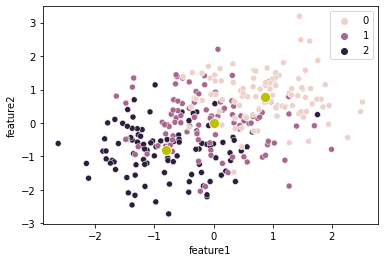

In [ ]:
print(X.shape, Class.shape)
centroids, cluster, loss_list = skfr2(X,Class,3,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)

In [ ]:
cluster

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

##Random Data

In [ ]:
features = 2
cases = 1000
k = 4
sparsity = 2
# X_random1 = np.random.normal(0,1,size=(features,cases//2))
# X_random2 = np.random.normal(4,1,size=(features,cases//2))
# X_random = np.concatenate((X_random1,X_random2),axis=1)
X_random = np.random.normal(0,1,size=(features,cases//k))
j = 4
p = 1
for i in range(k-1):
    tmp = np.random.normal(j,2,size=(features,cases//k))
    if i%2==0:
        tmp[0] = -1*tmp[0]
    j+=4
    X_random = np.concatenate((X_random,tmp),axis=1)
print(X_random.shape)
X_random = processed_data(X_random)

Class = np.array(random.choices([i for i in range(k)],k=cases))

(2, 1000)


[[ 8.03720498  7.76552317]
 [-4.32531834  4.23819042]
 [-0.28940695  0.07867252]
 [11.73210022 11.98709189]]


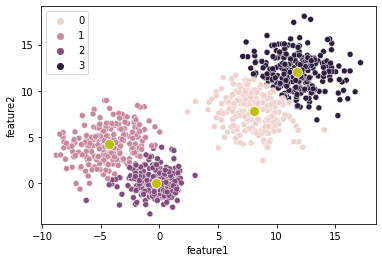

In [ ]:
centroids, cluster = kmeans(X_random.T, k)
print(centroids)
plot_clusters(X_random.T,centroids,cluster)

[[ 0.50721968  1.28629534]
 [-1.32468917 -0.68322846]
 [ 1.30424073 -0.26477764]
 [-0.03232656 -0.05010715]
 [ 0.0682356  -1.47563186]
 [-1.14011151  0.96724177]]


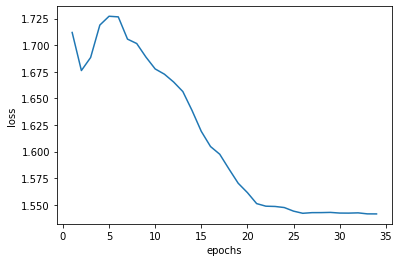

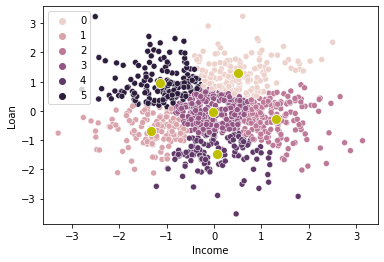

In [ ]:
centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X_random.T,centroids.T,cluster)

[[ 0.50721968  1.28629534]
 [-1.32468917 -0.68322846]
 [ 1.30424073 -0.26477764]
 [-0.03232656 -0.05010715]
 [ 0.0682356  -1.47563186]
 [-1.14011151  0.96724177]]


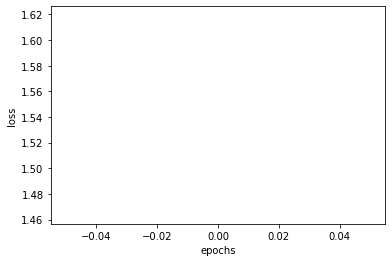

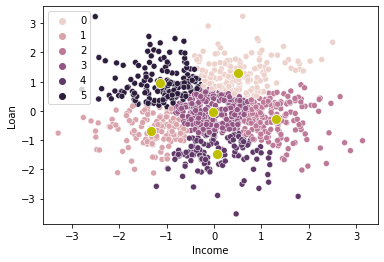

In [ ]:
centroids, cluster, loss_list = skfr2(X_random,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X_random.T,centroids.T,cluster)

##Input Dataset

In [ ]:
data = pd.read_csv('Data_Cortex_Nuclear.csv')
# data = pd.read_csv('clustering.csv')
data = data.dropna(axis=0,how='any')
Y = np.array(data['class'].astype('category').cat.codes)
data = data.select_dtypes(include='number')
# data.head(2)
# data = data.loc[:, ['ApplicantIncome', 'LoanAmount']]
data.head(2),np.unique(Y)

(    DYRK1A_N   ITSN1_N    BDNF_N  ...    EGR1_N  H3MeK4_N    CaNA_N
 75  0.649781  0.828696  0.405862  ...  0.146865  0.143517  1.627181
 76  0.616481  0.841974  0.388584  ...  0.161132  0.145719  1.562096
 
 [2 rows x 77 columns], array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int8))

In [ ]:
X = data.values.T

features = X.shape[0]
for i in range(features):
    X[i,:] = zscore(X[i,:])

centroids, cluster = kmeans(X.T, k=8)
print(centroids)
plot_clusters(X.T,centroids,cluster)
# print('Acc: ', np.mean(Y==cluster))
print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

In [ ]:
X = data.values.T

features = X.shape[0]
cases = X.shape[1]
k = 8
sparsity = 24

X = processed_data(X)
Class = np.array(random.choices([i for i in range(k)],k=cases))
# Class = Y
centroids, cluster, loss_list = skfr1(X,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)
# print('Acc: ', np.mean(Y==cluster))
print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

[[ 1.17964921  1.1853374   1.21320959  1.04766967  0.64858763  1.2120601
   1.21610002  0.          1.21637096  1.0042618   1.14906379  1.22075008
   1.21801982  1.2122311   1.18578731  1.19848061  1.11344206  1.05647036
   1.21151894  1.1873361   1.17112858  1.20621734  1.21623569  1.13218699
   0.99210915  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.05139757
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.9094093   1.71001424  0.
   0.          0.93303648  0.          0

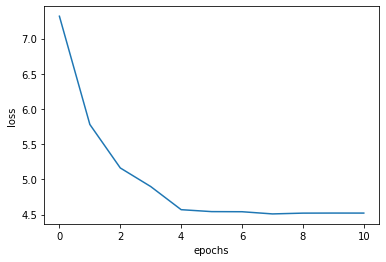

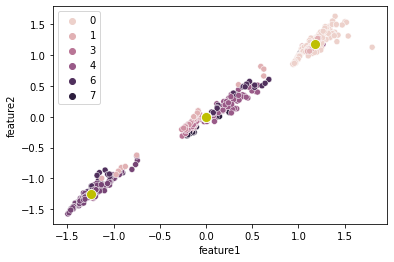

NMI:  0.5848767818317041
ARI:  0.3907442885980903


In [ ]:
X = data.values.T

features = X.shape[0]
cases = X.shape[1]
k = 8
sparsity = 24

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr2(X,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)
print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

## Thyroid Dataset

In [ ]:
columns = np.loadtxt('thyroid.dat', max_rows=1,dtype='str', delimiter=', ')
data = np.loadtxt('thyroid.dat', skiprows=1, dtype=np.float64, delimiter=', ')
data = pd.DataFrame(data,columns=columns)
data = data.dropna(axis=0,how='any')
Y = data['Class']
X_ = data.select_dtypes(include='number')
X_.head(2)


,Age,Sex,On_thyroxine,Query_on_thyroxine,On_antithyroid_medication,Sick,Pregnant,Thyroid_surgery,I131_treatment,Query_hypothyroid,Query_hyperthyroid,Lithium,Goitre,Tumor,Hypopituitary,Psych,TSH,T3,TT4,T4U,FTI,Class
0,0.73,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00060,0.015,0.120,0.082,0.146,3.0
1,0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00025,0.030,0.143,0.133,0.108,3.0


[0. 1. 2.]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.02126731  7.6487994   0.40295861  0.          0.
   0.          0.          0.          0.          0.09707951  0.
   0.          0.          0.         -0.14085385]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.73016554 -0.13073947  1.57795447  0.          0.
   0.          0.          0.          0.          0.78679073  0.
   0.          0.          0.         -1.61512745]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.11927848 -0.13073947 -0.26486709  0.          0.
   0.          0.          0.          0.         -0.13000267  0.
   0.          0.          0.          0.26570871]]


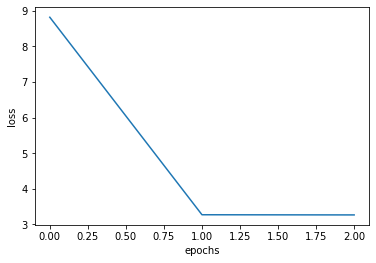

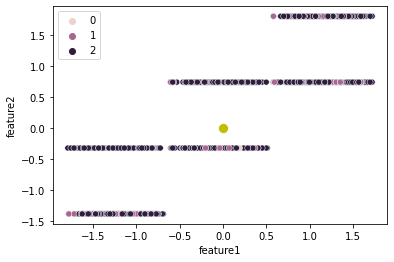

0.41268055364142975
ARI:  0.5483954920647586


In [ ]:
columns = np.loadtxt('thyroid.dat', max_rows=1,dtype='str', delimiter=', ')
data = np.loadtxt('thyroid.dat', skiprows=1, dtype=np.float64, delimiter=', ')
data = pd.DataFrame(data,columns=columns)
data = data.dropna(axis=0,how='any')
Y = data['Class'] - 1
print(np.unique(Y))
X_ = data.select_dtypes(include='number')
# X_.head(2)

X = X_.values.T

features = X.shape[0]
cases = X.shape[1]
k = 3
sparsity = 5

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr1(X,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)
print(nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

In [ ]:
Y -= 1
np.unique(Y)

array([0., 1., 2.])

[[-2.32842621e-03  6.70871763e-03 -4.05258513e-03 -2.78160496e-04
   6.49961014e-04  1.93281311e-03  0.00000000e+00 -5.90487528e-03
   3.45757283e-02  4.15257733e-02  2.63474899e-02 -1.24329746e-02
   2.92717090e-02 -8.80128934e-04 -1.17859315e-02 -8.37317455e-03
  -3.65185067e-03 -6.25315284e-02  1.21184078e-02  3.00875437e-02
  -2.03782849e-03 -7.59167740e-04]
 [-1.21406858e+00 -1.17989568e+00 -1.19442387e+00 -1.22045656e+00
  -1.22161290e+00 -1.21575919e+00 -1.22178240e+00 -9.44780045e-03
  -1.08049151e-02 -1.73959321e-02 -2.96409261e-02 -6.46514680e-02
  -7.70308131e-03 -6.16090253e-03  2.35718630e-02 -1.61022587e-02
  -1.98955020e-03  5.81522396e-02 -2.55877420e-02  4.03277889e-02
  -5.98847223e-02  0.00000000e+00]
 [ 1.21639701e+00  1.17318696e+00  1.19847646e+00  1.22073472e+00
   1.22096293e+00  1.21382637e+00  1.22178240e+00  1.53526757e-02
  -2.37708132e-02 -2.41298413e-02  3.29343624e-03  7.70844426e-02
  -2.15686277e-02  7.04103147e-03 -1.17859315e-02  2.44754333e-02
   5.6

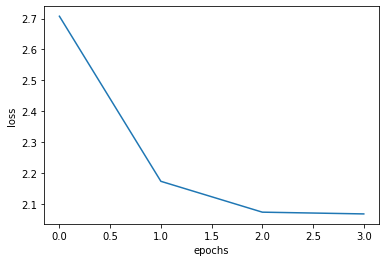

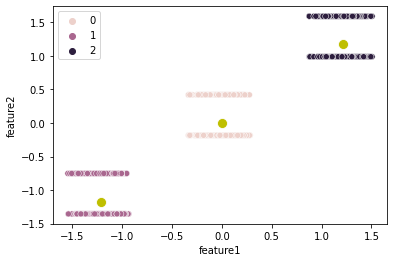

0.000288877493193194
ARI:  -1.8993142002988062e-05


In [ ]:
X = X_.values.T

features = X.shape[0]
cases = X.shape[1]
k = 3
sparsity = 21

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr2(X,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)
print(nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

##WARP10P

In [ ]:
# for sparsity in range(10,2400, 10):    
X_ = pd.read_csv('ar10px.csv', header=None).values
Y = (pd.read_csv('ar10py.csv', header=None).values-1).reshape(-1,)
# print(Y.shape)
# print(np.unique(Y))

X = X_.T

features = X.shape[0]
cases = X.shape[1]
k = 10
sparsity = 2000

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr1(X,Class,k,sparsity)
# print(centroids.T)
# plot_loss(loss_list)
# plot_clusters(X.T,centroids.T,cluster)
print('i= ',sparsity,'NMI: ', nmi(Y,cluster), end=" ")
print('ARI: ', ari(Y,cluster))

i=  2000 NMI:  0.2040972321389341 ARI:  0.02524756001994729
